In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
from os.path import join as pjoin
import json
print(os.getcwd())
sys.path.insert(0, pjoin(os.path.pardir))
sys.path.insert(0, pjoin(os.path.pardir, 'webapi'))
import numpy as np
import h5py
import math
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
from rttypes.volume import Volume
import dicomutils as du
import sparse
from planning.maskio import Mask
from skimage import measure

/media/raid1/qlyu/VHEE/code/dosecalc/jupyter_notebooks


ModuleNotFoundError: No module named 'rttypes'

In [180]:
def add_air_mask(ctdata_folder, bbox_file, sd_file, orig_file, new_file):
    masks = list(Mask.load_masks_from_file(orig_file).values())
    ctvol = Volume.fromDir(ctdata_folder)
    ctarr = ctvol.data
    density_size = ctarr.shape[::-1]
    print(density_size)
    with open(bbox_file, 'r') as fd:
        bbox = json.load(fd)
        print(bbox)
    sdmasks = Mask.load_masks_from_file(sd_file)
    
    dens_spacing = [float(x) for x in ctvol.frameofreference.spacing]
    assert bbox['spacing'] == dens_spacing
    offset = [int(math.floor((bbox['start'][ii]-ctvol.frameofreference.start[ii])/dens_spacing[ii])) for ii in range(3)]
    crop_slices = tuple([
        slice(offset[ii], offset[ii]+bbox['size'][ii],1)
        for ii in range(3)
    ][::-1])
    print(crop_slices)
    print(ctarr[crop_slices].shape, bbox['size'])
        
    airmask_arr = np.ones(density_size[::-1], dtype=np.uint8)
    airmask_arr[crop_slices] = sdmasks['T_AIR'].arr
    #airmask_arr[ctarr<0.1] = 1.0
    
    airmask = Mask()
    airmask.name = "T_AIR"
    airmask.arr = airmask_arr
    airmask.size = density_size
    airmask.crop_size = density_size
    airmask.crop_start = (0,0,0)
    slicenum= 90
    plt.figure(figsize=(10,10), dpi=150)
    plt.imshow(ctarr[slicenum], cmap='gray')
    plt.imshow(airmask_arr[slicenum], alpha=0.50, cmap='RdBu')
    plt.show()
    newmasks = list(masks)
    newmasks.append(airmask)
    Mask.save_masks_to_file(new_file, newmasks)
    

(260, 260, 174)
{'spacing': [2.5, 2.5, 2.5], 'start': [-240.0, -364.0, -657.0], 'size': [192, 113, 111]}
(slice(56, 167, 1), slice(75, 188, 1), slice(33, 225, 1))
(111, 113, 192) [192, 113, 111]


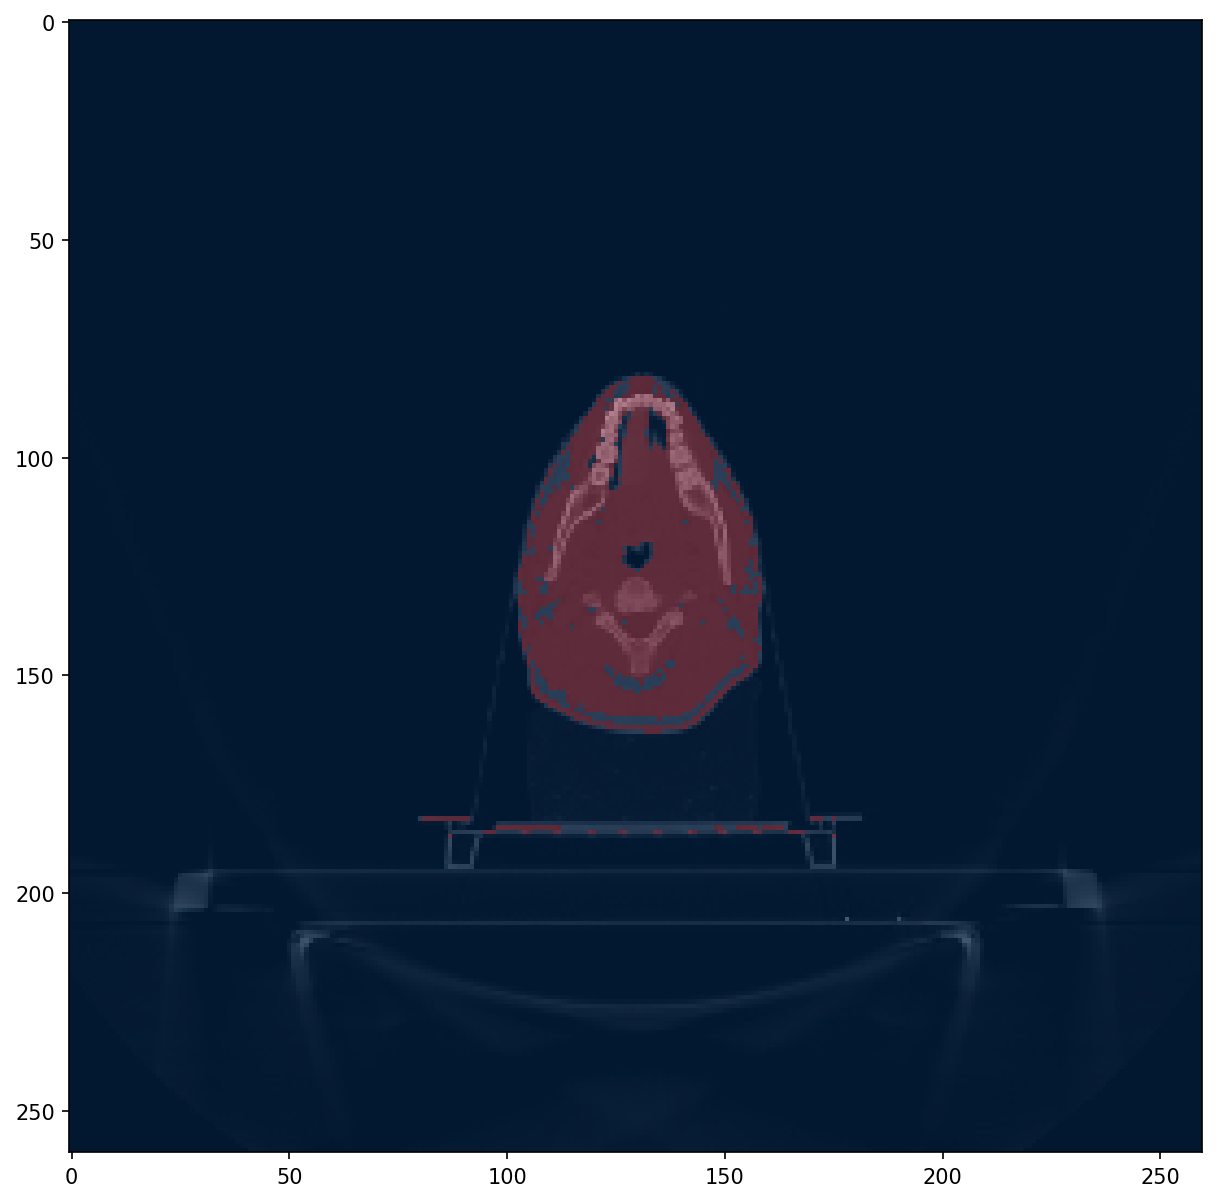

(230, 230, 172)
{'start': [-86.0, -347.0, -615.0], 'size': [67, 94, 62], 'spacing': [2.5, 2.5, 2.5]}
(slice(77, 139, 1), slice(50, 144, 1), slice(80, 147, 1))
(62, 94, 67) [67, 94, 62]


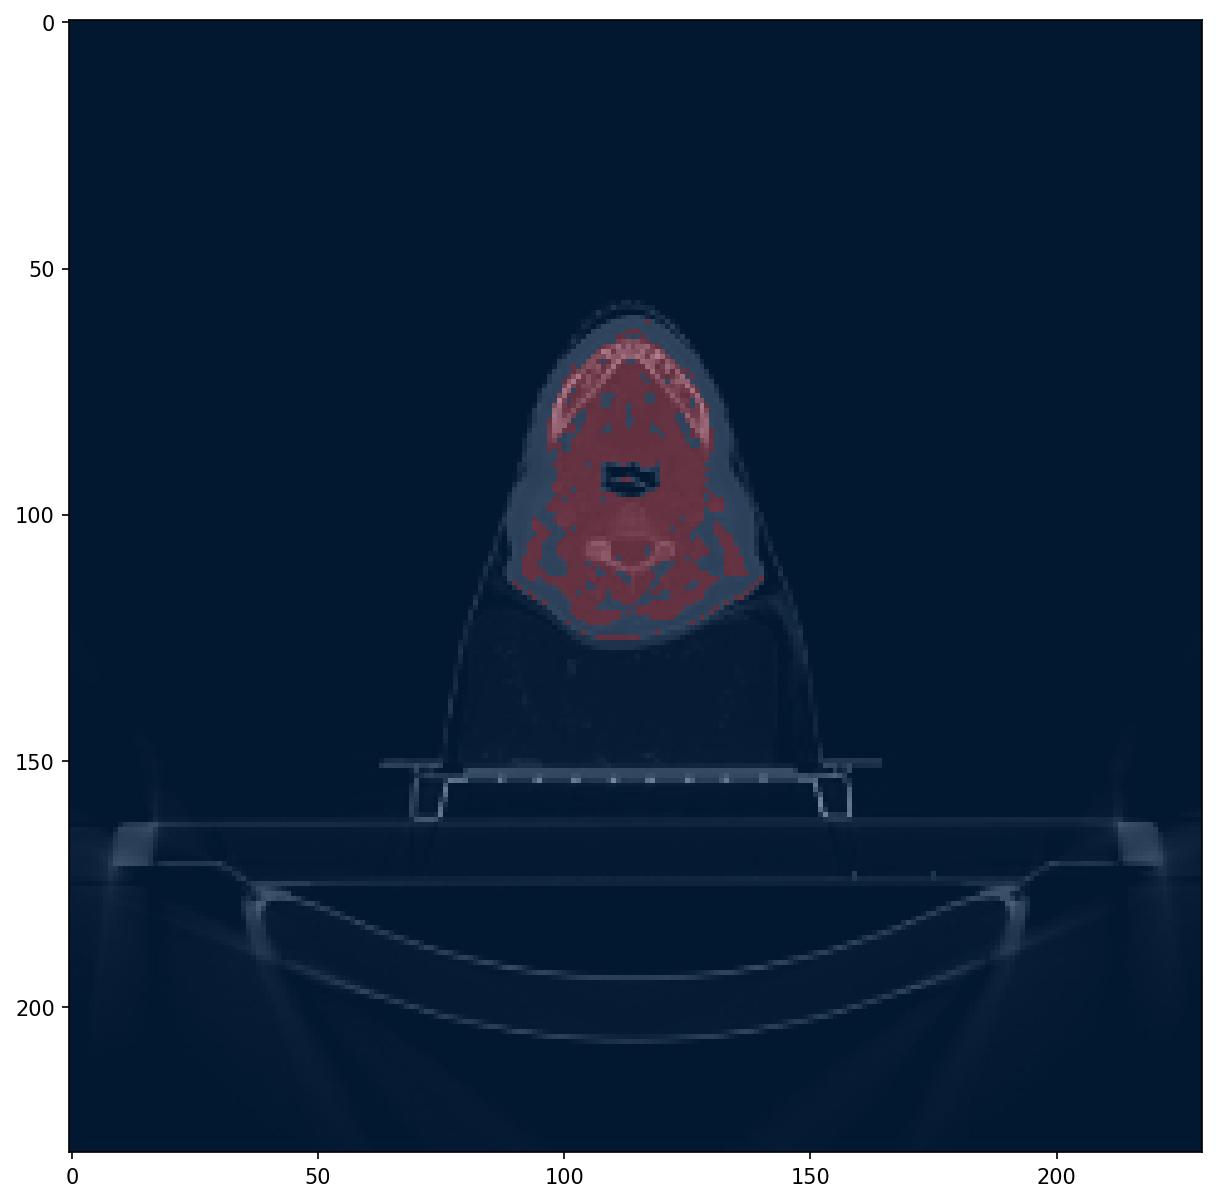

(220, 220, 191)
{'start': [-240.0, -359.0, -697.0], 'size': [192, 111, 122], 'spacing': [2.5, 2.5, 2.5]}
(slice(57, 179, 1), slice(39, 150, 1), slice(13, 205, 1))
(122, 111, 192) [192, 111, 122]


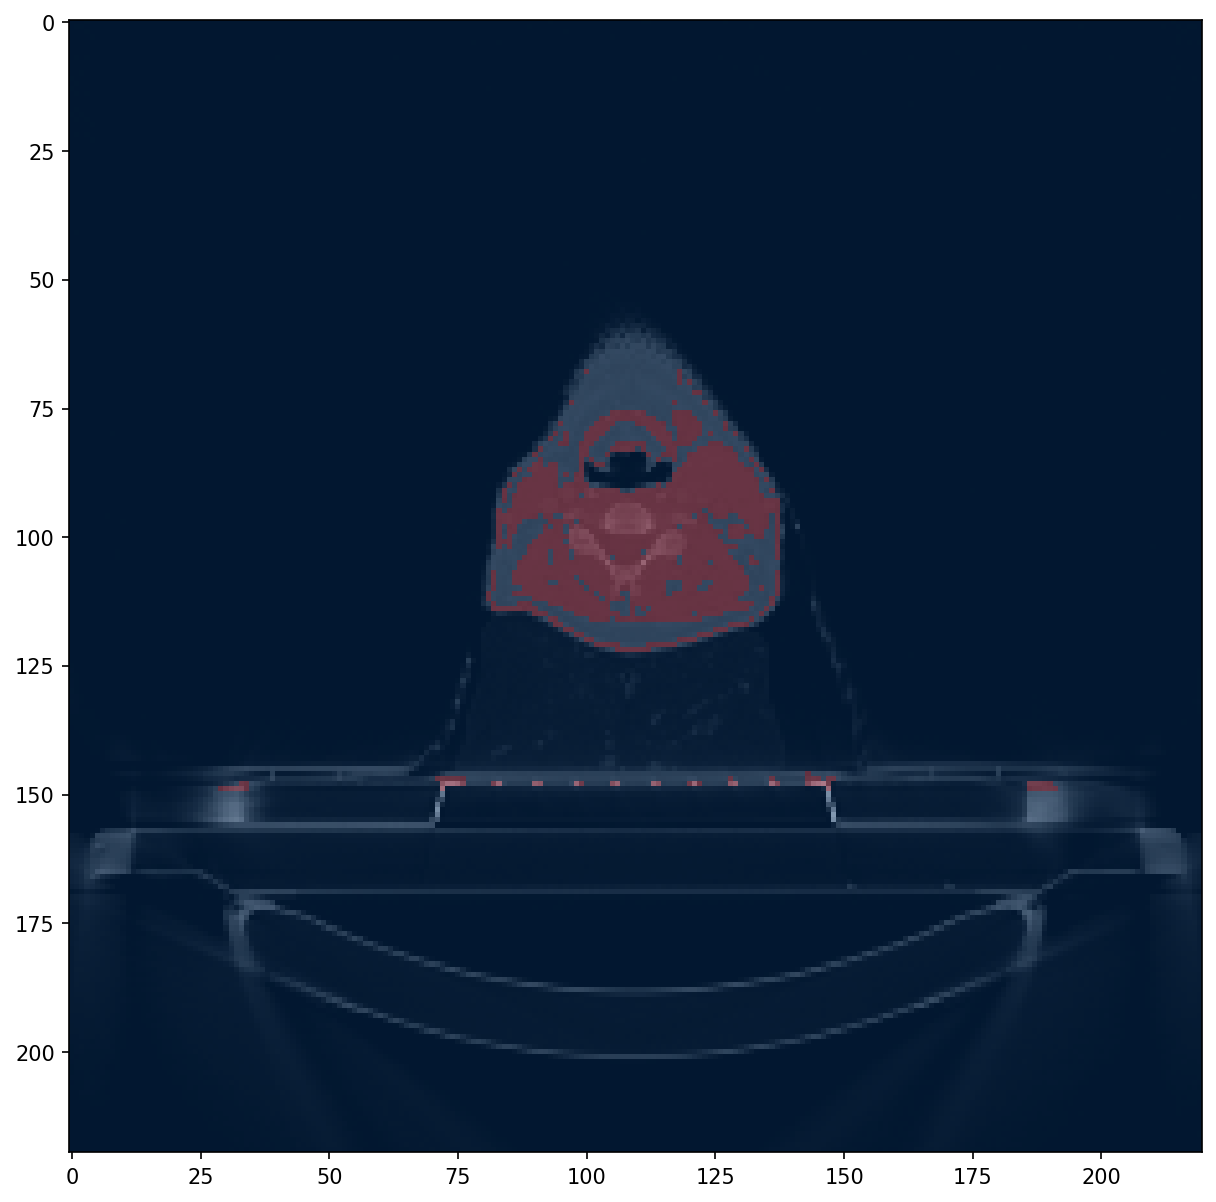

(220, 220, 191)
{'start': [-240.0, -359.0, -697.0], 'size': [192, 111, 122], 'spacing': [2.5, 2.5, 2.5]}
(slice(57, 179, 1), slice(39, 150, 1), slice(13, 205, 1))
(122, 111, 192) [192, 111, 122]


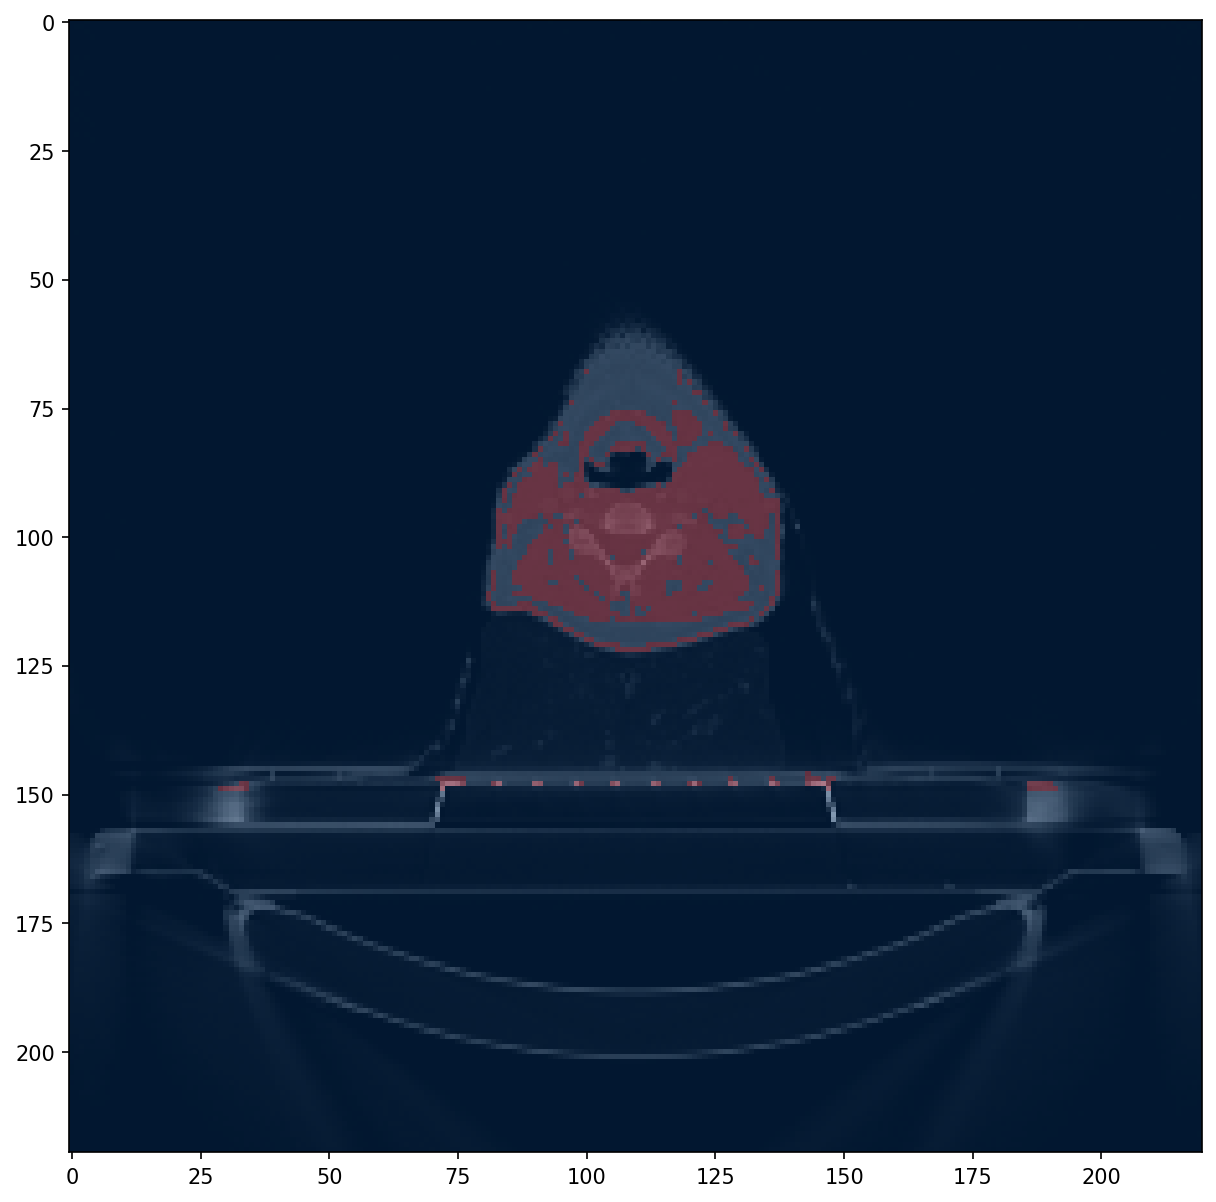

In [185]:
root = '/media/hdd1/g4sim/beamlet_dose/'
for doi in ['HN011', 'HN012']:
    ctdata_folder = pjoin(root, doi, 'CT')
    bbox_file = pjoin(root, doi, 'cropbox.json')
    orig_file = pjoin(root, doi, 'CCCS', 'beamlet_dose.mask')
    new_file = pjoin(root, doi, 'CCCS', 'beamlet_dose_wair.mask')
    sd_file = pjoin(root, doi, 'masks.h5')
    add_air_mask(ctdata_folder, bbox_file, sd_file, orig_file, new_file)
for ptv in ['PTV_5400', 'PTV_5940']:
    doi = 'HN010'
    ctdata_folder = pjoin(root, doi, 'CT')
    bbox_file = pjoin(root, doi, 'cropbox.json')
    orig_file = pjoin(root, doi, 'CCCS', ptv, 'beamlet_dose.mask')
    new_file = pjoin(root, doi, 'CCCS', ptv, 'beamlet_dose_wair.mask')
    sd_file = pjoin(root, doi, 'masks.h5')
    add_air_mask(ctdata_folder, bbox_file, sd_file, orig_file, new_file)
    